# Analyzing Unstructured Data

In this tutorial you will learn to:

* [web/screen scrape](https://en.wikipedia.org/wiki/Web_scraping) relatively unstructured data from the Wikipedia
* transform unstructured data into tabular data to facilitate processing with Python
* create graph data from your data to visualize your data as networks
* export Python-created data to use it with JavaScript visualization libraries such as [D3.js](https://d3js.org/)

Would you should already know:

* a little Python 3
* some minor HTML
* some JavaScript if you want to understand the web-based visualization at the end of the tutorial

This notebook assumes that you are using [Anaconda](https://www.anaconda.com/download/) as your Python 3 distribution.

# TODO

* DC und Marvel gegenüberstellen,
* WEbsite entsprechend anpassen
* auf Partnerships eingehen
* Konzepte in den Abilities bzw. Sentiments extrahieren
* entsprechende Wikipedia-Artikel auf Sentiments hin analysieren
* Korrelationen heraussuchen (einsame Superhelden mit negativen Artikeln in der Wikipedia?)

## Preparing Your Environment

In [220]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import networkx as nx # network analysis
import itertools
from datetime import datetime # for time measurement
import sys
import os
import unicodedata as ucd

# utility method that displays a given text and the current time
def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()

This notebook can be used to work with superheroes of the DC Comics or Marvel universe. However, only one universe can be processed at once.

In [221]:
isMarvel=False

if isMarvel:
    # Marvel
    imageDownloadPath="./web/force/img.marvel_chars/"
    localRelativeImagePath="img.marvel_chars/"
    csvFilePath="marvel_superheroes.csv"
    pathPrefix="marvel"
    printLog("Analysing Marvel universe...")
else:
    # DC Comics
    imageDownloadPath="./web/force/img.dc_chars/"
    localRelativeImagePath="img.dc_chars/"
    csvFilePath="dc_superheroes.csv"
    pathPrefix="dc"
    printLog("Analysing DC universe...")

# if the needed paths do not exist, create them
if not os.path.exists(imageDownloadPath):
    os.mkdir(imageDownloadPath)

[2021-03-01 10:33:15.405174]	Analysing DC universe...


## Screen-Scraping
Anaconda comes with _Beautiful Soup_, a library for screen-scraping [documentation](http://www.crummy.com/software/BeautifulSoup/bs4/doc/). The main idea is to download a HTML page from the Wikipedia, parse its contents, and save it in a structed way. This functionality is encapsulated in the function _extractData()_ (see below).

The relevant data is hidden in a table with the CSS class _infobox_. The _th_ tags serve as separators for the following information:
* <th scope="row" style="width: 40%;">Alter ego</th>
* <th scope="row" style="width: 40%;">Team affiliations</th>
* <th scope="row" style="width: 40%;">Partnerships</th>
* <th scope="row" style="width: 40%;">Notable aliases</th>
* <th scope="row" style="width: 40%;">Abilities</th>

The function also relies on [_regular expressions_](https://docs.python.org/2/howto/regex.html) - if you haven't heard of them before...

In [222]:
def extractData(myDoc): # myDoc is the HTML document to be parsed
    # initialize the screen-scraper
    soup = BeautifulSoup(myDoc, 'html.parser')
    # during an inspection of the Wikipedia HTML, we discovered that table elements with the CSS class infobox have to be parsed
    tables=soup.find_all('table',class_="infobox")
    # if there is no infobox, ignore the page
    if len(tables)>=1:
        # take the first infobox
        infoboxTable=tables[0]
        # try to get the name of the character
        if infoboxTable.tr.th is not None:
            name=infoboxTable.tr.th.get_text()
        else:
            #if it is not part of the infobox take it from the HTML page's title and strip the Wikipedia reference
            name=soup.title.get_text().replace(" - Wikipedia, the free encyclopedia","")
        # prepare variables for the data to be extracted
        abilityRow=None
        partnerRow=None
        firstAppearance="2020" # dummy entry in case the "first appearance" entry is missing
        abilities=[]
        partnerships=[]
        
        # save the provided image for later processing
        if infoboxTable.find('img'):
            articleImage=infoboxTable.find('img')["src"]
        else:
            articleImage=None

        p = re.compile('\d\d\d\d') # we expect the year of first appearance to have four digits
        
        rows=infoboxTable.find_all("tr")
        for row in rows:
            if row.th is not None and row.th.string == "First appearance":
                rawText=row.td.get_text()
                m = p.search(rawText)
                # deal with missing years of first appearance
                if m:
                    firstAppearance=m.group()
            elif row.th is not None and row.th.string == "Abilities":
                abilityRow=row
            elif row.th is not None and row.th.string == "Partnerships":
                partnerRow=row

        # as not every page has a "complete" infobox, we have to check the presence of abilities and partnerships
        if abilityRow is not None:
            li=abilityRow.find_all("li")
            for l in li:
                # check if an anchor (a link to a website) is contained
                if l.a is not None:
                    # if so, discard the link and keep the plain text
                    l.a.unwrap()
                abilities.append(l.get_text().strip())
        # a fix for abilities without the ul/li structure
            if len(li)==0:
                rawStr=str(abilityRow.td)
                rawStr=rawStr.replace("<td>","").replace("</td>","").replace("\n","").strip()
                # abilities are sometimes separated by  <br/>, a comma, a period, or "and"
                rawStr=rawStr.replace("<br/>",";")
                rawStr=rawStr.replace(",",";")
                rawStr=rawStr.replace(".",";")
                # we have to treat 'and' in a special way as it may be contained as a substring in "normal" words
                #rawStr=rawStr.replace("and",";")
                rawTokens=rawStr.split(" and ")
                rawStr=";".join(rawTokens)
                # remove all other HTML tags
                p2 = re.compile(r'<.*?>')
                rawStr=p2.sub(' ', rawStr)
                # clean whitespaces surrounding the string
                rawStr.strip()
                rawTokens=rawStr.split(";")
                for t in rawTokens:
                    t=t.strip()
                    # we have to ignore additional noise such as the following "abilities"
                    if t.lower()=="see below":
                        pass
                    elif t.lower()=="various":
                        pass
                    elif t.lower()=="varies":
                        pass
                    elif t.lower()=="none":
                        pass
                    else:
                        if str(t):
                            abilities.append(str(t))

        if partnerRow is not None:
            partners=partnerRow.find_all("a")
            for p in partners:
                if p.string is not None: # some Marvel pages "suffer" from empty <a>
                    partnerships.append(p.string)

        
        
        result=dict()
        result["name"]=name
        result["firstAppearance"]=int(firstAppearance)
        result["abilities"]=abilities
        result["abilitiesCount"]=len(abilities)
        result["partnerships"]=partnerships
        result["partnershipsCount"]=len(partnerships)
        if articleImage:
            result["imageURL"]="https:"+str(articleImage)
        else:
            result["imageURL"]="https://None"
        #print abilities
        return result
    else:
        return None

### Testing the Function
In order to find out whether the function works, we call it with two superheroes.

In [223]:
html_doc=urllib.request.urlopen("https://en.wikipedia.org/wiki/Juggernaut_(comics)")
r=extractData(html_doc)
print(r)

print("\n NEXT SUPERHERO\n")

html_doc=urllib.request.urlopen("https://en.wikipedia.org/wiki/Batman")
r=extractData(html_doc)
print(r)

{'name': 'Juggernaut', 'firstAppearance': 1965, 'abilities': ['Superhuman strength', 'stamina', 'durability', 'Invulnerability via mystical force field', 'Unstoppable momentum', 'Immunity to mental attacks via his helmet'], 'abilitiesCount': 6, 'partnerships': ['Black Tom Cassidy'], 'partnershipsCount': 1, 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/thumb/4/44/Juggernaut2.PNG/250px-Juggernaut2.PNG'}

 NEXT SUPERHERO

{'name': 'BatmanBruce Wayne', 'firstAppearance': 1939, 'abilities': ['Genius intellect', 'Expert detective', 'Skilled martial artist and hand-to-hand combatant', 'Master tactician, strategist, and field commander', 'Utilizing high-tech equipment'], 'abilitiesCount': 5, 'partnerships': ['Robin', 'Alfred Pennyworth', 'James Gordon', 'Harvey Dent', 'Catwoman', 'Batgirl', 'Superman', 'Wonder Woman'], 'partnershipsCount': 8, 'imageURL': 'https://upload.wikimedia.org/wikipedia/en/c/c7/Batman_Infobox.jpg'}


However, the reality is more complex but the Wikipedia provides lists of superheroes of the different universes.

In [224]:
categoryPages=[]
if not isMarvel:
    # DC superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pageuntil=Dragon+King%0ADragon+King+%28DC+Comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Krypto#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=Robin%0ARobin+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_superheroes&pagefrom=XS+%28comics%29#mw-pages")
    # general DC characters
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pageuntil=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:DC_Comics_characters&pagefrom=Smoak%2C+Felicity%0AFelicity+Smoak#mw-pages")
else:
    # Marvel superheroes
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pageuntil=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Dazzler#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Jameson%0AJohn+Jameson+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Prime+%28Comics%29%0APrime+%28comics%29#mw-pages")
    categoryPages.append("https://en.wikipedia.org/w/index.php?title=Category:Marvel_Comics_superheroes&pagefrom=Talon+%28Marvel+Comics%29#mw-pages")

The following function expects Wikipedia category pages as provided above and retrieves the URLs of relevant superhero Wikipedia articles.

In [225]:
def getSuperheroes(myCategories,myDictionary):
    for c in myCategories:
    # ignore <a class="mw-redirect"> as they redirect into articles, 
    # to be precise, we only consider <a> tags without a class atrribute 
    # because we are only interested in superheroes with distinct wikipedia articles
        items=c.ul.find_all("li")
        for item in items:
            if item.a.get("class") is None:
                myDictionary[item.a["title"]]=item.a["href"]


startTime=datetime.now()
printLog("Fetching superhero URLs...")

superheroes=OrderedDict() # we use an ordered dict here because we want to preserve the order items were added
for catPage in categoryPages:
    html_doc=urllib.request.urlopen(catPage)
    soup = BeautifulSoup(html_doc, 'html.parser')
    categories=soup.select("#mw-pages")[0].select(".mw-category-group")
    getSuperheroes(categories,superheroes) # we pass the superheroes dictionary on to merge the heroes extracted from all pages

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2021-03-01 10:33:18.074080]	Fetching superhero URLs...
[2021-03-01 10:33:21.916015]	Processing completed in 0:00:03.841926.


Given a list of URLs, we can extract the data for each superhero.

In [226]:
wikiBaseURL="https://en.wikipedia.org"
heroFeats=[]
i=0;
countItems=len(superheroes)

printLog("Processing "+str(countItems)+" Wikipedia pages. This will take a while...")

startTime=datetime.now()


for key, value in superheroes.items():
    i=i+1
    wikiURL=wikiBaseURL+value
    #print "Processing "+wikiURL+" ; "+str(i)+" of "+str(countItems)
    html_doc=urllib.request.urlopen(wikiURL)
    r=extractData(html_doc)
    if r:
        r["url"]=wikiURL
        heroFeats.append(r)
    else:
        print("\t"+wikiURL+" does not contain an infobox. Processing aborted.")

duration=datetime.now()-startTime
printLog("Processing completed in "+str(duration)+".")

[2021-03-01 10:33:21.925224]	Processing 545 Wikipedia pages. This will take a while...
	https://en.wikipedia.org/wiki/List_of_Metal_Men_members does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Wildebeest_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Robert_Crichton_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Ironwolf_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Johnny_Reb does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Lady_Luck_(comics) does not contain an infobox. Processing aborted.
	https://en.wikipedia.org/wiki/Red_Ryan_(comics) does not contain an infobox. Processing aborted.
[2021-03-01 10:35:37.601387]	Processing completed in 0:02:15.675219.


Additionally, we will download the character images if there are some.

In [237]:
printLog("Downloading images. This will take a while...")

startTime=datetime.now()
# downloading images

if not os.path.exists(imageDownloadPath):
    os.makedirs(imageDownloadPath)

for i,hero in enumerate(heroFeats):
    hero["localFilePath"]="N/A" # caveat of JSON http://stackoverflow.com/questions/13715891/d3-json-uncaught-typeerror-cannot-read-property-children-of-undefined
    iURL=hero["imageURL"]
    if not iURL=="https://None":
        tokens=iURL.split(".")
        suffix=tokens[-1]
        localFilePath=imageDownloadPath+str(i)+"."+suffix
        # debug
        #print("Downloading to: "+localFilePath)
        hero["localFilePath"]=localRelativeImagePath+str(i)+"."+suffix
        try:
            urllib.request.urlretrieve(iURL,localFilePath)
        except IOError: # if we would catch all other exception, we would have a hard time to stop the kernel at all
            print("Downloading error while accessing: "+hero["imageURL"]+ "and/or saving in: "+localFilePath)
            #print(IOError)
            #break
duration=datetime.now()-startTime
printLog("Downloading completed in "+str(duration)+".")

[2021-03-01 11:14:47.147236]	Downloading images. This will take a while...
[2021-03-01 11:15:48.461856]	Downloading completed in 0:01:01.313464.


## Converting the Raw Data into Tables

For further processing relying on Python's typical data science libraries, it is handy to save the data in a Pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), a tabular data structure with built-in support for various analytical tasks.

In [238]:
rows=[]
columns=["Name","Year","Decade","Abilities","AbilitiesCount","Partnerships","PartnershipsCount","URL","ImageURL","localFilePath"]

# take each hero and save attributes in a data frame
for hero in heroFeats:
    #print(hero["name"])
    rowx=[]
    rowx.append(hero["name"])
    firstAp=hero["firstAppearance"]
    rowx.append(firstAp)
    # calculate the decade
    if firstAp<2000:
        rowx.append(1900+int((hero["firstAppearance"]-1900)/10)*10)
    else:
        rowx.append(2000+int((hero["firstAppearance"]-2000)/10)*10)
    rowx.append(",".join(hero["abilities"]))
    rowx.append(hero["abilitiesCount"])
    rowx.append(",".join(hero["partnerships"]))
    rowx.append(hero["partnershipsCount"])
    rowx.append(hero["url"])
    rowx.append(hero["imageURL"])
    rowx.append(hero["localFilePath"])
    rows.append(rowx)

df=pd.DataFrame(rows,columns=columns)
df.head() # display the top rows of the data frame

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath
0,Abin Sur,1959,1950,Green Lantern power ring,1,,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/
1,Agent Liberty,1991,1990,"Expert in military tactics,Skilled hand-to-han...",3,,0,https://en.wikipedia.org/wiki/Agent_Liberty,https://upload.wikimedia.org/wikipedia/en/6/69...,img.dc_chars/
2,Air Wave,1942,1940,,0,,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/
3,Talia al Ghul,1971,1970,"Genius-level intellect,Master martial artist a...",7,"Ra's al Ghul,Deathstroke,Batman,Damian Wayne",4,https://en.wikipedia.org/wiki/Talia_al_Ghul,https://upload.wikimedia.org/wikipedia/en/e/e6...,img.dc_chars/
4,Barry Allen,2013,2010,,0,,0,https://en.wikipedia.org/wiki/Barry_Allen_(Arr...,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/


Unfortunately, the table is not ready for processing. For instance, the superheroe's name are using lower and upper case letters which would complicate later comparisons. There are also encoding issues. Hence, we normalize textual date before we continue with the analysis.

To simplify the code, we rely on [lambda functions](https://www.w3schools.com/python/python_lambda.asp), anonymous functions that get applied on most attributes of the data frame. In order to be non-destructive, we save the results in separate columns.

In [239]:
# to avoid spelling issues, we capitalize all superheroes' names
# lambda Konzept erläutern
try:
    df['NameCaps'] = df.Name.apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['NameCaps'] = df.Name.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
#    utf8str=row[13].decode('utf-8')
#    str2=ucd.normalize('NFKD', utf8str).encode('ascii','ignore')
try:
    df['PartnershipsCaps'] = df.Partnerships.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['PartnershipsCaps'] = df.Partnerships.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
try:
    df['AbilitiesCaps'] = df.Abilities.astype(str).apply(lambda x: x.upper())
except(UnicodeEncodeError):
    df['AbilitiesCaps'] = df.Abilities.apply(lambda x: ucd.normalize('NFKD', unicode(x)).encode('ascii','ignore').upper())
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abin Sur,1959,1950,Green Lantern power ring,1,,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ABIN SUR,,GREEN LANTERN POWER RING
1,Agent Liberty,1991,1990,"Expert in military tactics,Skilled hand-to-han...",3,,0,https://en.wikipedia.org/wiki/Agent_Liberty,https://upload.wikimedia.org/wikipedia/en/6/69...,img.dc_chars/,AGENT LIBERTY,,"EXPERT IN MILITARY TACTICS,SKILLED HAND-TO-HAN..."
2,Air Wave,1942,1940,,0,,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,AIR WAVE,,
3,Talia al Ghul,1971,1970,"Genius-level intellect,Master martial artist a...",7,"Ra's al Ghul,Deathstroke,Batman,Damian Wayne",4,https://en.wikipedia.org/wiki/Talia_al_Ghul,https://upload.wikimedia.org/wikipedia/en/e/e6...,img.dc_chars/,TALIA AL GHUL,"RA'S AL GHUL,DEATHSTROKE,BATMAN,DAMIAN WAYNE","GENIUS-LEVEL INTELLECT,MASTER MARTIAL ARTIST A..."
4,Barry Allen,2013,2010,,0,,0,https://en.wikipedia.org/wiki/Barry_Allen_(Arr...,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,BARRY ALLEN,,


Finally, we save the results as a CSV file. However, Excel, a database, or many more other formats would also be possible. This is also a good place to take a rest and continue later on.

In [240]:
# save to file without the index columns of the data frame and separate each field with a tabstop
df.to_csv(csvFilePath,index=False,header=True,encoding='utf-8', sep="\t")

## Continuing the Analysis
If you have shutdown the notebook before, you can read in the data again with [read_csv()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

In [241]:
df=pd.read_csv(csvFilePath,encoding='utf-8', sep="\t",dtype={"Partnerships":'str'})
df.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abin Sur,1959,1950,Green Lantern power ring,1,NaN,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ABIN SUR,NaN,GREEN LANTERN POWER RING
1,Agent Liberty,1991,1990,"Expert in military tactics,Skilled hand-to-han...",3,NaN,0,https://en.wikipedia.org/wiki/Agent_Liberty,https://upload.wikimedia.org/wikipedia/en/6/69...,img.dc_chars/,AGENT LIBERTY,NaN,"EXPERT IN MILITARY TACTICS,SKILLED HAND-TO-HAN..."
2,Air Wave,1942,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,AIR WAVE,NaN,NaN
3,Talia al Ghul,1971,1970,"Genius-level intellect,Master martial artist a...",7,"Ra's al Ghul,Deathstroke,Batman,Damian Wayne",4,https://en.wikipedia.org/wiki/Talia_al_Ghul,https://upload.wikimedia.org/wikipedia/en/e/e6...,img.dc_chars/,TALIA AL GHUL,"RA'S AL GHUL,DEATHSTROKE,BATMAN,DAMIAN WAYNE","GENIUS-LEVEL INTELLECT,MASTER MARTIAL ARTIST A..."
4,Barry Allen,2013,2010,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Barry_Allen_(Arr...,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,BARRY ALLEN,NaN,NaN


Next, we will test wheter all superhero names are unique - a valid hypothesis...

In [242]:
countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print("Attention! Names are not unique.")

Total number of names: 538, Unique number of names: 506
Attention! Names are not unique.


Unfortunately, the names are not unique.
To drop the duplicates, we apply a rather simple strategy: we keep the oldest, i.e., the first appearing, superheroes using pandas utility function [drop_duplicates()](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.drop_duplicates.html).

In [243]:
df.drop_duplicates(subset='NameCaps',keep='first',inplace=True)

countNames=df.NameCaps.count()
uniqueNames=len(df.NameCaps.unique())

print("Total number of names: %d, Unique number of names: %d" % (countNames,uniqueNames))
if countNames!=uniqueNames:
    print("Attention! Names are not unique.")

Total number of names: 506, Unique number of names: 506


After we made sure that every superhero appears only once, we will try to find out if there are "lone wolf" characters. These heros are copied into a new data frame.
Further selections are made for demonstration purposes...

In [244]:
# the "lonely" superheroes are created from the original data frame selecting each row where the column "Partnerships" is Null (not set)
df2=df[df["Partnerships"].isnull()]
df2.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abin Sur,1959,1950,Green Lantern power ring,1,NaN,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ABIN SUR,NaN,GREEN LANTERN POWER RING
1,Agent Liberty,1991,1990,"Expert in military tactics,Skilled hand-to-han...",3,NaN,0,https://en.wikipedia.org/wiki/Agent_Liberty,https://upload.wikimedia.org/wikipedia/en/6/69...,img.dc_chars/,AGENT LIBERTY,NaN,"EXPERT IN MILITARY TACTICS,SKILLED HAND-TO-HAN..."
2,Air Wave,1942,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,AIR WAVE,NaN,NaN
4,Barry Allen,2013,2010,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Barry_Allen_(Arr...,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,BARRY ALLEN,NaN,NaN
5,Barry AllenThe Flash,2016,2010,"Immense superhuman speed, stamina, reflexes, a...",4,NaN,0,https://en.wikipedia.org/wiki/Barry_Allen_(DC_...,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,BARRY ALLENTHE FLASH,NaN,"IMMENSE SUPERHUMAN SPEED, STAMINA, REFLEXES, A..."


In [245]:
# the "sociable" superheroes
df3=df[df["Partnerships"].notnull()]
df3.head()

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
3,Talia al Ghul,1971,1970,"Genius-level intellect,Master martial artist a...",7,"Ra's al Ghul,Deathstroke,Batman,Damian Wayne",4,https://en.wikipedia.org/wiki/Talia_al_Ghul,https://upload.wikimedia.org/wikipedia/en/e/e6...,img.dc_chars/,TALIA AL GHUL,"RA'S AL GHUL,DEATHSTROKE,BATMAN,DAMIAN WAYNE","GENIUS-LEVEL INTELLECT,MASTER MARTIAL ARTIST A..."
6,Bart Allen,1994,1990,"Immense Superhuman speed,Superhuman stamina,Su...",16,"Barry Allen,Wally West,Jay Garrick,Max Mercury...",6,https://en.wikipedia.org/wiki/Bart_Allen,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,BART ALLEN,"BARRY ALLEN,WALLY WEST,JAY GARRICK,MAX MERCURY...","IMMENSE SUPERHUMAN SPEED,SUPERHUMAN STAMINA,SU..."
11,Anarky,1989,1980,"Child prodigy,Cunning tactician,Weapon/tool im...",7,Legs,1,https://en.wikipedia.org/wiki/Anarky,https://upload.wikimedia.org/wikipedia/en/4/4d...,img.dc_chars/,ANARKY,LEGS,"CHILD PRODIGY,CUNNING TACTICIAN,WEAPON/TOOL IM..."
12,Animal Man,1965,1960,Ability to gain the powers of any animal that ...,1,Swamp Thing,1,https://en.wikipedia.org/wiki/Animal_Man,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ANIMAL MAN,SWAMP THING,ABILITY TO GAIN THE POWERS OF ANY ANIMAL THAT ...
14,Apache Chief,2020,2020,"Ability to grow in size,Speak and understand t...",4,"El Dorado,Samurai,Black Vulcan",3,https://en.wikipedia.org/wiki/Apache_Chief,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,APACHE CHIEF,"EL DORADO,SAMURAI,BLACK VULCAN","ABILITY TO GROW IN SIZE,SPEAK AND UNDERSTAND T..."


In [246]:
# the oldest superhero(ine)
df[df['Year']==df['Year'].min()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
321,The Shadow,1930,1930,"Expert detective,Skilled marksman and hand-to-...",6,NaN,0,https://en.wikipedia.org/wiki/The_Shadow,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,THE SHADOW,NaN,"EXPERT DETECTIVE,SKILLED MARKSMAN AND HAND-TO-..."


In [247]:
# get the superhero with the maximal number of abilities
df[df['AbilitiesCount']==df['AbilitiesCount'].max()]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
209,Miss Martian,2006,2000,"Superhuman strength, speed, durability and end...",34,NaN,0,https://en.wikipedia.org/wiki/Miss_Martian,https://upload.wikimedia.org/wikipedia/en/2/2d...,img.dc_chars/,MISS MARTIAN,NaN,"SUPERHUMAN STRENGTH, SPEED, DURABILITY AND END..."
351,Star-Spangled kid,1941,1940,"Sylvester Pemberton, Jr.\nSuper athlete\nHand ...",34,NaN,0,https://en.wikipedia.org/wiki/Star-Spangled_Kid,https://None,NaN,STAR-SPANGLED KID,NaN,"SYLVESTER PEMBERTON, JR.\nSUPER ATHLETE\nHAND ..."


In [248]:
# select superheroes that first appeared during 1939 and 1945
df[(df.Year>=1939) & (df.Year<1945)]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
2,Air Wave,1942,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Air_Wave,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,AIR WAVE,NaN,NaN
18,Aquaman,1941,1940,"Superhuman strength, durability, endurance, sp...",6,"Queen Mera,Aqualad,Topo,Prince Garth/Tempest,S...",6,https://en.wikipedia.org/wiki/Aquaman,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,AQUAMAN,"QUEEN MERA,AQUALAD,TOPO,PRINCE GARTH/TEMPEST,S...","SUPERHUMAN STRENGTH, DURABILITY, ENDURANCE, SP..."
24,Atom,1940,1940,"Atomic strength and agility,Superb athlete,Pro...",5,Atom Smasher,1,https://en.wikipedia.org/wiki/Atom_(Al_Pratt),https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ATOM,ATOM SMASHER,"ATOMIC STRENGTH AND AGILITY,SUPERB ATHLETE,PRO..."
34,BatmanBruce Wayne,1939,1930,"Genius intellect,Expert detective,Skilled mart...",5,"Robin,Alfred Pennyworth,James Gordon,Harvey De...",8,https://en.wikipedia.org/wiki/Batman,https://upload.wikimedia.org/wikipedia/en/c/c7...,img.dc_chars/,BATMANBRUCE WAYNE,"ROBIN,ALFRED PENNYWORTH,JAMES GORDON,HARVEY DE...","GENIUS INTELLECT,EXPERT DETECTIVE,SKILLED MART..."
36,Thomas Wayne,1939,1930,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Thomas_Wayne,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,THOMAS WAYNE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,Martha Wayne,1939,1930,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Martha_Wayne,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,MARTHA WAYNE,NaN,NaN
532,Ebony White,1940,1940,NaN,0,NaN,0,https://en.wikipedia.org/wiki/Ebony_White,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,EBONY WHITE,NaN,NaN
533,Woozy Winks,1942,1940,NaN,0,Plastic Man,1,https://en.wikipedia.org/wiki/Woozy_Winks,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,WOOZY WINKS,PLASTIC MAN,NaN
534,"Winky, Blinky, and Noddy",1942,1940,NaN,0,NaN,0,"https://en.wikipedia.org/wiki/Winky,_Blinky,_a...",https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,"WINKY, BLINKY, AND NODDY",NaN,NaN


In [249]:
# the not so gifted superheroes with only one ability
df[df['AbilitiesCount']==1]

,Name,Year,Decade,Abilities,AbilitiesCount,Partnerships,PartnershipsCount,URL,ImageURL,localFilePath,NameCaps,PartnershipsCaps,AbilitiesCaps
0,Abin Sur,1959,1950,Green Lantern power ring,1,NaN,0,https://en.wikipedia.org/wiki/Abin_Sur,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ABIN SUR,NaN,GREEN LANTERN POWER RING
10,"Amethyst, Princess of Gemworld",1983,1980,Magic,1,NaN,0,"https://en.wikipedia.org/wiki/Amethyst,_Prince...",https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,"AMETHYST, PRINCESS OF GEMWORLD",NaN,MAGIC
12,Animal Man,1965,1960,Ability to gain the powers of any animal that ...,1,Swamp Thing,1,https://en.wikipedia.org/wiki/Animal_Man,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,ANIMAL MAN,SWAMP THING,ABILITY TO GAIN THE POWERS OF ANY ANIMAL THAT ...
33,Bat-Mite,1959,1950,Reality warping,1,NaN,0,https://en.wikipedia.org/wiki/Bat-Mite,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,BAT-MITE,NaN,REALITY WARPING
42,The Beefeater,1989,1980,Power Rod,1,NaN,0,https://en.wikipedia.org/wiki/Beefeater_(chara...,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,THE BEEFEATER,NaN,POWER ROD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Mademoiselle Marie,1959,1950,Markswoman,1,NaN,0,https://en.wikipedia.org/wiki/Mademoiselle_Marie,https://None,NaN,MADEMOISELLE MARIE,NaN,MARKSWOMAN
508,Olivia Reynolds,1969,1960,U-Mind (which contains a civilization living i...,1,NaN,0,https://en.wikipedia.org/wiki/Olivia_Reynolds,https://None,NaN,OLIVIA REYNOLDS,NaN,U-MIND (WHICH CONTAINS A CIVILIZATION LIVING I...
513,Silas Stone,1980,1980,Genius-level intellect,1,NaN,0,https://en.wikipedia.org/wiki/Silas_Stone,https://None,NaN,SILAS STONE,NaN,GENIUS-LEVEL INTELLECT
516,Space Cabbie,1954,1950,Expert driver,1,NaN,0,https://en.wikipedia.org/wiki/Space_Cabbie,https://upload.wikimedia.org/wikipedia/en/thum...,img.dc_chars/,SPACE CABBIE,NaN,EXPERT DRIVER


After inspecting the last selection, we see that the abilities column is not in [first normal form](https://en.wikipedia.org/wiki/First_normal_form) and the abilities count is not correct for every superhero. Hence, we should consider to split the abilities column and update abilitiesCount accordingly.

### Statistics
If we want to get a general "feeling" about our data frame, the _describe()_ method becomes handy as it computes various statstics for you.

In [250]:
df.describe()

,Year,Decade,AbilitiesCount,PartnershipsCount
count,506.000000,506.000000,506.000000,506.000000
mean,1975.464427,1971.521739,4.195652,0.322134
std,24.188610,24.443439,4.831340,1.140169
min,1930.000000,1930.000000,0.000000,0.000000
25%,1958.250000,1950.000000,1.000000,0.000000
50%,1977.000000,1970.000000,3.000000,0.000000
75%,1993.000000,1990.000000,6.000000,0.000000
max,2020.000000,2020.000000,34.000000,9.000000


Numerical data can also be plotted in form of histograms.

array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Decade'}>],
       [<AxesSubplot:title={'center':'AbilitiesCount'}>,
        <AxesSubplot:title={'center':'PartnershipsCount'}>]], dtype=object)

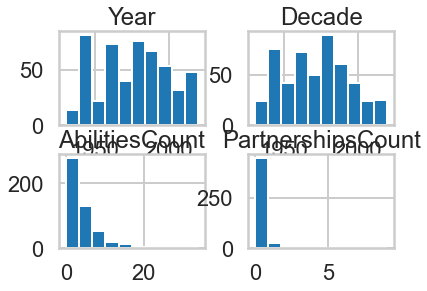

In [251]:
df.hist()

To facilitate reading, histograms can also be based on selected columns.

<AxesSubplot:>

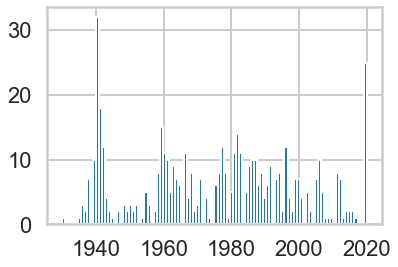

In [252]:
df['Year'].hist(bins=100) # bins determines the number of vertical bars

More complex plots are also possible.

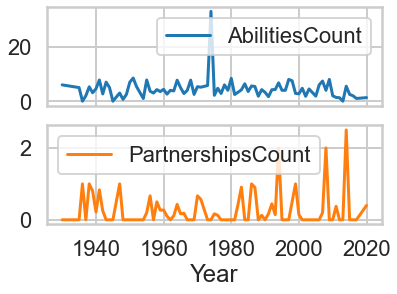

In [253]:
# docs: http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
#fig = plt.figure()
df[['AbilitiesCount','PartnershipsCount','Year']].groupby("Year").mean().plot(subplots=True)
MaxValue = df['Year'].max()
plt.show()

## Create a Graph from our Data

In the next step, we will create a graph from our data linking the superheroes with their partners and their abilities. Eventually, this will help us to discover which superheroes share abilities.

In [254]:
def createAbilityPartnershipGraphs(consideredDataFrame):
    # for testing purposes it is handy to limit the number of records
    #consideredDataFrame=consideredDataFrame[(consideredDataFrame.Year>=1961) & (consideredDataFrame.Year<1975)]

    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()
    G_abilities=nx.Graph()
    
    # DEBUG dictionaries for ID output
    heroIDs=dict()
    heroID=0
    abilityIDs=dict()
    abilityID=0

    # .itertuples() gives us an iterator over all rows in a data frame
    for row in consideredDataFrame.itertuples():
        hero=row[11]
        year=row[2]
        decade=row[3]
        if not hero in heroIDs:
            heroIDs[hero]=heroID
            heroID=heroID+1
            
        if not hero in G.nodes():
            # debug
            #G.add_node(hero)
            # überall wo nun heroNr steht, stand hero
            heroNr=heroIDs[hero]
            G.add_node(heroIDs[hero])
            # the name attribute will be helpful for D3.js visualizations (see below)
            G.nodes[heroNr]['name'] = hero
            G.nodes[heroNr]['year'] = year
            G.nodes[heroNr]['decade'] = decade
            G.nodes[heroNr]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G.nodes[heroNr]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G.nodes[heroNr]['localFilePath']=localFilePath
            else:
                G.nodes[heroNr]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        if not hero in G_abilities.nodes():
            # debug
            #G_abilities.add_node(hero)
            G_abilities.add_node(heroIDs[hero])
            # überall wo nun heroID steht, stand hero
            heroNr=heroIDs[hero]
            
            G_abilities.nodes[heroNr]['name'] = hero
            G_abilities.nodes[heroNr]['year'] = year
            G_abilities.nodes[heroNr]['decade'] = decade
            G_abilities.nodes[heroNr]['group'] = 2 # will change the display color in D3.js and will be used if a text label has to be plotted for this node
            G_abilities.nodes[heroNr]['picture']=row[9]
            localFilePath=str(row[10])
            if not localFilePath.upper()=="NAN":
                G_abilities.nodes[heroNr]['localFilePath']=localFilePath
            else:
                G_abilities.nodes[heroNr]['localFilePath']="N/A" # must not be left empty, otherwise corrupt JSON will be created below

        # treat partnerships  (PartnershipsCount)  
        if row[7]: # a shortcut to find out whether a string is empty
            if not row[12]=="NAN":
                partners=row[12].split(",")
                for partner in partners:
                    if not partner in G.nodes():
                        G.add_node(partner)
                        G.nodes[partner]['name'] = partner
                        G.nodes[partner]['year'] = year
                        G.nodes[partner]['decade'] = decade
                        G.nodes[partner]['group'] = 2
                    G.add_edge(hero,partner)
                    G[hero][partner]['year'] = year
                    G[hero][partner]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    edgeList=G.edges(partner,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G.nodes[e[0]]['year'] = "XXX"

        # treat abilities
        if row[5]: #AbilitiesCount
            if not row[13]=="NAN":
                abilities=str(row[13]).split(",")
                for ab in abilities:
                    if not ab in abilityIDs:
                        abilityIDs[ab]=abilityID
                        abilityID=abilityID+1
                        
                    if not ab in G_abilities.nodes():
                        #debug
                        #G_abilities.add_node(ab)
                        G_abilities.add_node(abilityIDs[ab])
                        # überall wo nun abID steht, stand ab
                        abID=abilityIDs[ab]
                        
                        G_abilities.nodes[abID]['name'] = ab
                        G_abilities.nodes[abID]['year'] = year
                        G_abilities.nodes[abID]['decade'] = decade
                        G_abilities.nodes[abID]['group'] = 1 # will change the display color in D3.js
                        #debug
                     
                    #debug 
                    #G_abilities.add_edge(hero,ab)
                    #G_abilities[hero][ab]['year'] = year
                    #G_abilities[hero][ab]['decade'] = decade
                    G_abilities.add_edge(heroIDs[hero],abID)
                    G_abilities[heroIDs[hero]][abID]['year'] = year
                    G_abilities[heroIDs[hero]][abID]['decade'] = decade
                    # this is a tricky part that is only needed for the later visualization of the results with D3.js
                    # during visualization, we want to hide elements of the graph depending on the associated year.
                    # however, ability nodes linked to different hero nodes (and thus years) must not be hidden.
                    # to prevent this, we check for such nodes and give them a dummy year.
                    #debug
                    #edgeList=G_abilities.edges(ab,data=True)
                    edgeList=G_abilities.edges(abID,data=True)
                    if len(edgeList)>1:
                        for e in edgeList:
                            G_abilities.nodes[e[0]]['year'] = "XXX"
                    print("Adding edge: "+hero+" - "+str(ab))
                #G_abilities.add_edges_from(list(itertools.product(abilities,abilities))) # macht ein cross product der abilities
    return [G,G_abilities]

# DEBUG
#r=createAbilityPartnershipGraphs(df.head(30))
r=createAbilityPartnershipGraphs(df)

G=r[0]
G_abilities=r[1]

print("Statistics of the superhero partnership graph.")
print(G.number_of_nodes())
print(G.number_of_edges())

print("\nStatistics of the superhero ability graph.")
print(G_abilities.number_of_nodes())
print(G_abilities.number_of_edges())

Adding edge: ABIN SUR - GREEN LANTERN POWER RING
Adding edge: AGENT LIBERTY - EXPERT IN MILITARY TACTICS
Adding edge: AGENT LIBERTY - SKILLED HAND-TO-HAND COMBATANT AND MARKSMAN
Adding edge: AGENT LIBERTY - UTILIZES WEAPONIZED BATTLE SUIT EQUIPPED WITH RETRACTABLE BLADES
Adding edge: AGENT LIBERTY -  A FORCEFIELD GENERATOR
Adding edge: AGENT LIBERTY -  AND A JET PACK FOR FLIGHT
Adding edge: TALIA AL GHUL - GENIUS-LEVEL INTELLECT
Adding edge: TALIA AL GHUL - MASTER MARTIAL ARTIST AND HAND-TO-HAND COMBATANT
Adding edge: TALIA AL GHUL - SKILLED SWORDSMAN AND MARKSMAN
Adding edge: TALIA AL GHUL - CHARISMA
Adding edge: TALIA AL GHUL - RESURRECTION
Adding edge: TALIA AL GHUL - LONGEVITY
Adding edge: TALIA AL GHUL - SLOWED AGING
Adding edge: BARRY ALLENTHE FLASH - IMMENSE SUPERHUMAN SPEED
Adding edge: BARRY ALLENTHE FLASH -  STAMINA
Adding edge: BARRY ALLENTHE FLASH -  REFLEXES
Adding edge: BARRY ALLENTHE FLASH -  AGILITY
Adding edge: BARRY ALLENTHE FLASH -  SENSES
Adding edge: BARRY ALLENTHE

Adding edge: STALKER - SUPERHUMAN STRENGTH
Adding edge: STALKER - SENSES
Adding edge: STALKER - SPEED
Adding edge: STALKER - VARIOUS MYSTICAL ABILITIES
Adding edge: STALKER - EXPERT FENCER
Adding edge: STAR SAPPHIRE - VARIOUS POWERS ANALOGOUS TO THOSE OF A  VIOLET LANTERN   POWER RING
Adding edge: STAR SAPPHIRE - INCLUDING ENERGY CONSTRUCTS
Adding edge: STAR SAPPHIRE - EXTREME DURABILITY
Adding edge: STAR SAPPHIRE - SELF-PROPELLED FLIGHT
Adding edge: STAR SAPPHIRE - ALSO POSSESSES A HOST OF LOVE-THEMED ABILITIES
Adding edge: STAR-SPANGLED KID - SYLVESTER PEMBERTON
Adding edge: STAR-SPANGLED KID -  JR.
SUPER ATHLETE
HAND TO HAND COMBATANT
COSMIC CONVERTER BELT
COURTNEY WHITMORE
EXPERT GYMNAST AND KICKBOXER
ENHANCED STRENGTH
Adding edge: STAR-SPANGLED KID -  SPEED
Adding edge: STAR-SPANGLED KID -  AGILITY AND STAMINA
ABILITY TO PROJECT SHOOTING STARS
FLIGHT
COSMIC ENERGY MANIPULATION
MISS MARTIAN
SUPERHUMAN STRENGTH
Adding edge: STAR-SPANGLED KID -  SPEED
Adding edge: STAR-SPANGLED KID -

## Using the Data in Your Website

If you want to display the data on an interactive website for a wider audience, Jupyter notebooks might no longer be appropriate. Fortunately, the networkx package allows us to export the graph data as JSON files which can be easily read by JavaScript.

In [255]:
import json
from networkx.readwrite import json_graph

# create needed subdirectories
if not os.path.exists('./web/force/'):
    os.mkdir('./web/force/')
if not os.path.exists('./web/force/'+pathPrefix+"/"):
    os.mkdir('./web/force/'+pathPrefix+"/")

#d = json_graph.node_link_data(G)
d = json_graph.node_link_data(G_abilities)

    
jsonPath='./web/force/'+pathPrefix+'/force.json'
json.dump(d, open(jsonPath,'w'))

printLog("Saved JSON file to: "+jsonPath)
# weitere notwendige Files für D3.js visualization unter: /Users/david/Documents/src/javascript/visualization
# examples taken from https://github.com/networkx/networkx/tree/master/examples/javascript

[2021-03-01 11:17:33.021161]	Saved JSON file to: ./web/force/dc/force.json


As graphs can be become to large to be displayed responsively, we will also export the data separated by decades.

In [256]:
decades=[1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
dataframes=OrderedDict()
for decade in decades:
    dfTemp=df[(df.Decade==decade)]
    dataframes[decade]=dfTemp

In [257]:
df[df.Decade==2020].describe()

,Year,Decade,AbilitiesCount,PartnershipsCount
count,25.0,25.0,25.000000,25.0
mean,2020.0,2020.0,1.320000,0.4
std,0.0,0.0,1.725302,1.0
min,2020.0,2020.0,0.000000,0.0
25%,2020.0,2020.0,0.000000,0.0
50%,2020.0,2020.0,0.000000,0.0
75%,2020.0,2020.0,3.000000,0.0
max,2020.0,2020.0,5.000000,3.0


In [258]:
groupedStats=df[['AbilitiesCount','PartnershipsCount',"Decade"]].groupby("Decade").count()
groupedStats.to_csv("./web/force/"+pathPrefix+"/decadeStats.csv")

In [259]:
for decade in dataframes:
    currentDF=dataframes[decade]
    r=createAbilityPartnershipGraphs(currentDF)
    d = json_graph.node_link_data(r[1])
    jsonPath='./web/force/'+pathPrefix+"/"+str(decade)+'.json'
    json.dump(d, open(jsonPath,'w'))

    printLog("Saved JSON file to: "+jsonPath)

[2021-03-01 11:17:40.764543]	Saved JSON file to: ./web/force/dc/1900.json
[2021-03-01 11:17:40.768162]	Saved JSON file to: ./web/force/dc/1910.json
[2021-03-01 11:17:40.771531]	Saved JSON file to: ./web/force/dc/1920.json
Adding edge: BATMANBRUCE WAYNE - GENIUS INTELLECT
Adding edge: BATMANBRUCE WAYNE - EXPERT DETECTIVE
Adding edge: BATMANBRUCE WAYNE - SKILLED MARTIAL ARTIST AND HAND-TO-HAND COMBATANT
Adding edge: BATMANBRUCE WAYNE - MASTER TACTICIAN
Adding edge: BATMANBRUCE WAYNE -  STRATEGIST
Adding edge: BATMANBRUCE WAYNE -  AND FIELD COMMANDER
Adding edge: BATMANBRUCE WAYNE - UTILIZING HIGH-TECH EQUIPMENT
Adding edge: BOZO THE IRON MAN - FLIGHT
Adding edge: CRIMSON AVENGER - (TRAVIS)
Adding edge: CRIMSON AVENGER - TRAINED SOLDIER
Adding edge: CRIMSON AVENGER - SKILLED MARTIAL ARTIST
Adding edge: CRIMSON AVENGER - (ELWOOD)
Adding edge: CRIMSON AVENGER - GIFTED INVENTOR
Adding edge: CRIMSON AVENGER - (CARLYLE)
Adding edge: CRIMSON AVENGER - TELEPORTATION
Adding edge: CRIMSON AVENGER 

Adding edge: ABIN SUR - GREEN LANTERN POWER RING
Adding edge: AQUAGIRL - ADAPTED FOR BREATHING UNDERWATER
Adding edge: AQUAGIRL - RESISTING DEEP-SEA-LEVEL PRESSURE
Adding edge: AQUAGIRL - POSSESSES SUPER STRENGTH
Adding edge: AQUAGIRL - TOUGHNESS
Adding edge: BAT-MITE - REALITY WARPING
Adding edge: BATWOMAN - HIGHLY SKILLED MARTIAL ARTIST
Adding edge: BATWOMAN - HIGHLY SKILLED DETECTIVE
Adding edge: BATWOMAN - UTILIZES HIGH-TECH EQUIPMENT AND WEAPONS
Adding edge: BATWOMAN - MASTERY OF STEALTH AND TACTICS
Adding edge: BIZARRO - SUPERHUMAN STRENGTH
Adding edge: BIZARRO -  HEARING
Adding edge: BIZARRO -  AND ENDURANCE
Adding edge: BIZARRO - SUPER-SONIC-SPEED
Adding edge: BIZARRO - FLIGHT
Adding edge: BIZARRO - HEALING FACTOR
Adding edge: BIZARRO - INVULNERABILITY
Adding edge: BIZARRO - FREEZE
Adding edge: BIZARRO -  SPOT-LIGHT
Adding edge: BIZARRO -  X-RAY
Adding edge: BIZARRO -  TELESCOPIC
Adding edge: BIZARRO -  AND MICROSCOPIC VISION
Adding edge: BIZARRO - HEAT AND VACUUM BREATH
Adding

Adding edge: GIM ALLON - AS COLOSSAL BOY
Adding edge: GIM ALLON - LEVIATHAN :
Adding edge: GIM ALLON - EXPAND HIS BODY TO GIANT SIZE
Adding edge: GIM ALLON - SUPERHUMAN STRENGTH
Adding edge: GIM ALLON - MASS
Adding edge: GIM ALLON - AS MICRO LAD :
Adding edge: GIM ALLON - SHRINK SIZE OF HIS BODY
Adding edge: ANIMAL MAN - ABILITY TO GAIN THE POWERS OF ANY ANIMAL THAT EXISTS OR HAS EXISTED VIA ACCESS TO "THE RED"
Adding edge: AQUALAD - CAN BREATHE UNDERWATER
Adding edge: AQUALAD - CAN SWIM AT SUPERSPEED
Adding edge: AQUALAD - SUPERSTRENGTH
Adding edge: AQUALAD - CAN WITHSTAND UNDERWATER PRESSURES
Adding edge: ATOMIC KNIGHT - PRECOGNITION
Adding edge: ATOMIC KNIGHT - WEARS A SUIT OF ARMOR GRANTING ENHANCED STRENGTH
Adding edge: ATOMIC KNIGHT - SPEED
Adding edge: ATOMIC KNIGHT - ENDURANCE
Adding edge: ATOMIC KNIGHT - BLASTS OF ENERGY
Adding edge: ATOMIC KNIGHT - AS WELL AS BEING ADAPTABLE TO OTHER TECHNOLOGY
Adding edge: B'WANA BEAST - TELEPATHIC CONTROL OVER ANIMALS
Adding edge: B'WANA BE

Adding edge: TALIA AL GHUL - GENIUS-LEVEL INTELLECT
Adding edge: TALIA AL GHUL - MASTER MARTIAL ARTIST AND HAND-TO-HAND COMBATANT
Adding edge: TALIA AL GHUL - SKILLED SWORDSMAN AND MARKSMAN
Adding edge: TALIA AL GHUL - CHARISMA
Adding edge: TALIA AL GHUL - RESURRECTION
Adding edge: TALIA AL GHUL - LONGEVITY
Adding edge: TALIA AL GHUL - SLOWED AGING
Adding edge: BATMAN - GENIUS-LEVEL INTELLIGENCE
Adding edge: BATMAN - MASTER DETECTIVE
Adding edge: BATMAN - PEAK HUMAN PHYSICAL CONDITION
Adding edge: BATMAN - MARTIAL ARTS MASTER
Adding edge: BATMAN - ESCAPOLOGIST
Adding edge: BATMAN - EXPERT  VENTRILOQUIST
Adding edge: BATMAN - ACCESS TO HIGH TECH EQUIPMENT
Adding edge: BEOWULF - EXPERT  SWORDSMAN
Adding edge: BEOWULF - SUPERHUMAN STRENGTH
Adding edge: BEOWULF - SPEED
Adding edge: BLACK LIGHTNING - ELECTROKINESIS
Adding edge: BLACK LIGHTNING - ENERGY ABSORPTION
Adding edge: BLACK LIGHTNING - FORCE FIELD GENERATION
Adding edge: BLACK LIGHTNING - EXPERT MARTIAL ARTIST
Adding edge: BLACK LIG

[2021-03-01 11:17:40.984031]	Saved JSON file to: ./web/force/dc/1970.json
Adding edge: AMBUSH BUG - CAN TELEPORT TO ANYWHERE IN THE  MULTIVERSE  (EXACT LIMITS ARE NOT DEFINED)
Adding edge: AMBUSH BUG - GREEN SUIT PROVIDES LIMITED PROTECTION FROM SOME ATTACKS
Adding edge: AMETHYST, PRINCESS OF GEMWORLD - MAGIC
Adding edge: ANARKY - CHILD PRODIGY
Adding edge: ANARKY - CUNNING TACTICIAN
Adding edge: ANARKY - WEAPON/TOOL IMPROVISATION
Adding edge: ANARKY - SKILLED HACKER
Adding edge: ANARKY - PROFICIENT INVENTOR
Adding edge: ANARKY - HYBRID MARTIAL ARTIST
Adding edge: ANARKY - AMPLIFIED INTELLIGENCE
Adding edge: ANTIOPE - ENHANCED STRENGTH
Adding edge: ANTIOPE - ENHANCED SPEED
Adding edge: ANTIOPE - ENHANCED DURABILITY
Adding edge: ANTIOPE - HIGHLY DEVELOPED FIGHTING SKILLS
Adding edge: ARAK - EXPERT SWORDSMAN
Adding edge: ARAK - ARCHER
Adding edge: ARAK - TRACKER
Adding edge: ARAK - EARTH MANIPULATION
Adding edge: ARAK - ILLUSION CASTING
Adding edge: ARAK - LONGEVITY
Adding edge: ARAK - M

Adding edge: SUPERGIRL KARA ZOR-EL/LINDA LEE - AMNESIA-INDUCING TOUCH
Adding edge: TERRA - CREATION OF FISSURES
Adding edge: TERRA -  AVALANCHES
Adding edge: TERRA -  EARTHQUAKES AND MUDSLIDES
Adding edge: TERRA - SURF ON A BOULDER FOR FASTER MIDAIR TRANSPORTATION
Adding edge: TERRA - ERECT WALLS OF SOLID STONE OR ROCK FOR PROTECTION
Adding edge: TERRA - BRING FORTH AUTONOMOUS CREATURES COMPOSED OF ROCK AND STONE
Adding edge: TERRA - TRIGGER THE ERUPTION OF VOLCANOES
Adding edge: TERRA - CONTROL AND MANIPULATION OVER LAVA AND MAGMA
Adding edge: TERRA - GEOKINESIS
Adding edge: TERRA - LEADERSHIP SKILLS
Adding edge: TERRA - MASTER MANIPULATOR
Adding edge: TERRA - DOUBLE AGENT
Adding edge: TERRA - MASTER OF DECEPTION AND DUPLICITY
Adding edge: THUNDER AND LIGHTNING - CAN GENERATE THUNDER
Adding edge: THUNDER AND LIGHTNING - LIGHTNING
Adding edge: THUNDER AND LIGHTNING - TELEPORT
Adding edge: THUNDER AND LIGHTNING - PSYCHIC LINK
Adding edge: THUNDER AND LIGHTNING - WHEN THEY ARE TOGETHER
A

Adding edge: TECHNOCRAT - SUIT OF POWERED ARMOR
Adding edge: THE RAY - GENERATION OF LIGHT
Adding edge: THE RAY - SOLID LIGHT CONSTRUCTS
Adding edge: THE RAY - CONVERSION TO ENERGY FORM
Adding edge: THE RAY - FLIGHT
Adding edge: JAKEEM THUNDER - ABILITY TO SUMMON
Adding edge: JAKEEM THUNDER - CONTROL A POWERFUL GENIE
Adding edge: JAKEEM THUNDER - THE THUNDERBOLT
Adding edge: TOMAR-TU - POWER RING
Adding edge: TOMORROW WOMAN - TELEKINESIS
Adding edge: TOMORROW WOMAN - TELEPATHY
Adding edge: TOMORROW WOMAN - LETHAL EMP WEAPON
Adding edge: COURTNEY WHITMORE - EXPERT GYMNAST AND KICKBOXER
Adding edge: COURTNEY WHITMORE - ENHANCED STRENGTH
Adding edge: COURTNEY WHITMORE -  SPEED
Adding edge: COURTNEY WHITMORE -  AGILITY AND STAMINA
Adding edge: COURTNEY WHITMORE - ABILITY TO PROJECT SHOOTING STARS
Adding edge: COURTNEY WHITMORE - FLIGHT
Adding edge: COURTNEY WHITMORE - COSMIC ENERGY MANIPULATION
Adding edge: ROSE WILSON - PRECOGNITIVE ABILITY TO SEE INTO THE FUTURE
Adding edge: ROSE WILSON 

[2021-03-01 11:17:41.171532]	Saved JSON file to: ./web/force/dc/2000.json
Adding edge: BARRY ALLENTHE FLASH - IMMENSE SUPERHUMAN SPEED
Adding edge: BARRY ALLENTHE FLASH -  STAMINA
Adding edge: BARRY ALLENTHE FLASH -  REFLEXES
Adding edge: BARRY ALLENTHE FLASH -  AGILITY
Adding edge: BARRY ALLENTHE FLASH -  SENSES
Adding edge: BARRY ALLENTHE FLASH -  HEALING FACTOR
Adding edge: BARRY ALLENTHE FLASH -  AND ENDURANCE
Adding edge: BARRY ALLENTHE FLASH - MOLECULAR INTANGIBILITY
Adding edge: BARRY ALLENTHE FLASH - TIME TRAVEL AND MANIPULATION
Adding edge: BARRY ALLENTHE FLASH -  DIMENSION TRAVEL
Adding edge: BARRY ALLENTHE FLASH - ELECTRICITY AND LIGHTNING MANIPULATION
Adding edge: BATWING - MASTER MARTIAL ARTIST
Adding edge: BATWING - FLIGHT VIA SUIT'S WINGS
Adding edge: BATWING - ARSENAL OF WEAPONS
Adding edge: BATWING - HIGH-TECH GADGETS
Adding edge: BATWING - SKILLED DETECTIVE
Adding edge: SIMON BAZGREEN LANTERN - GUN
Adding edge: SIMON BAZGREEN LANTERN - UNIFORM (SUIT AND MASK)
Adding e

## Displaying the Results

Now we are set to display the results in a browser. However, to prevent security warnings, we cannot directly open the HTML files saved in the web/ directory. Hence, we launch a built-in Python webserver for display.

_ATTENTION_ Never interrupt the kernel after you have started the following cell. Just press <ENTER> in the input field displayed in the cell below.

If you have accidently interrupted the kernel, Python will not release the listener on port 8000. Thus, you will not be able to re-run the following cell. To solve the problem, you must restart the whole Jupyter notebook process.

In [260]:
# if you make changes to http_server.py you will have to delete http_server.pyc manually
import http_server
if isMarvel:
    http_server.load_url('./web/force/force_marvel.html')
else:
    http_server.load_url('./web/force/force_dc.html')

Webserver working directory: /Users/david/src/CulturalAnalytics


127.0.0.1 - - [01/Mar/2021 11:17:43] "GET /web/force/force_dc.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2021 11:17:48] code 404, message File not found
127.0.0.1 - - [01/Mar/2021 11:17:48] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Mar/2021 11:17:48] "GET /web/force/force.js HTTP/1.1" 304 -
127.0.0.1 - - [01/Mar/2021 11:17:48] "GET /web/force/dc/decadeStats.csv HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2021 11:17:48] "GET /web/force/dc/force.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Mar/2021 11:17:49] "GET /web/force/img.dc_chars/ HTTP/1.1" 200 -


Press <RETURN> to stop server

To restart server run: 
python -m http.server 8000
